In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
import chardet
from IPython.display import Markdown

plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

In [2]:
os.listdir('.')

['.gitignore',
 'gun_violence_eda.ipynb',
 '.ipynb_checkpoints',
 'nst-est2016-01.xlsx',
 'gun-violence-data_01-2013_03-2018.csv',
 '.git']

In [3]:
# check what the character encoding might be
with open('gun-violence-data_01-2013_03-2018.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))

print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [4]:
df = pd.read_csv('gun-violence-data_01-2013_03-2018.csv', index_col='incident_id', parse_dates=[1])

In [5]:
 df.columns

Index(['date', 'state', 'city_or_county', 'address', 'n_killed', 'n_injured',
       'incident_url', 'source_url', 'incident_url_fields_missing',
       'congressional_district', 'gun_stolen', 'gun_type',
       'incident_characteristics', 'latitude', 'location_description',
       'longitude', 'n_guns_involved', 'notes', 'participant_age',
       'participant_age_group', 'participant_gender', 'participant_name',
       'participant_relationship', 'participant_status', 'participant_type',
       'sources', 'state_house_district', 'state_senate_district'],
      dtype='object')

In [6]:
# removing unuseful columns 
df.drop(labels=['address', 'incident_url', 'incident_url_fields_missing', 'congressional_district',
                'participant_name', 'sources', 'state_house_district', 'state_senate_district', 
                'participant_age_group', 'participant_relationship', 'gun_stolen'], axis=1, inplace=True)

In [7]:
# number of people who killed or injured
df['n_killed_injured'] = df['n_killed'] + df['n_injured']
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

In [8]:
df.dtypes

date                        datetime64[ns]
state                               object
city_or_county                      object
n_killed                             int64
n_injured                            int64
source_url                          object
gun_type                            object
incident_characteristics            object
latitude                           float64
location_description                object
longitude                          float64
n_guns_involved                    float64
notes                               object
participant_age                     object
participant_gender                  object
participant_status                  object
participant_type                    object
n_killed_injured                     int64
year                                 int64
month                                int64
weekday                              int64
dtype: object

# Plot map of incidents

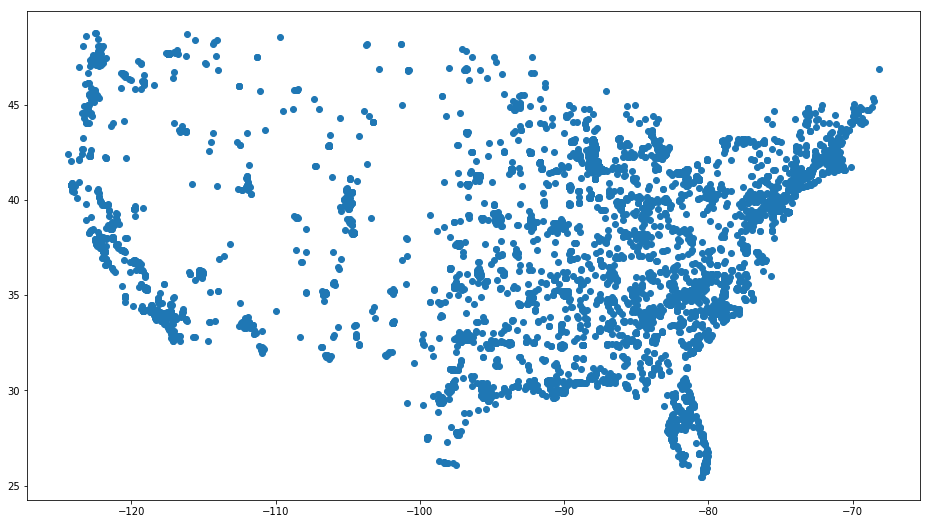

In [9]:
temp = df[['latitude', 'longitude']].copy()

# removing Hawaii, Alaska and some anomalies
temp = temp.loc[temp['longitude'].between(-125, -40) & temp['latitude'].between(25, 50), :]
temp = temp.dropna().sample(10000)
plt.figure(figsize=(16, 9))
plt.scatter(temp['longitude'], temp['latitude']);

# Major facts about our dataset

In [10]:
total_incidents = df.shape[0]
zero_killed_or_injured = df.loc[(df['n_killed'] == 0) & (df['n_injured']  == 0)].shape[0]

Markdown("""
### In {} thousand incidents there is {:2.0f}% injured or killed people.
""".format(total_incidents // 1000, (total_incidents - zero_killed_or_injured) * 100 / total_incidents))


### In 239 thousand incidents there is 59% injured or killed people.


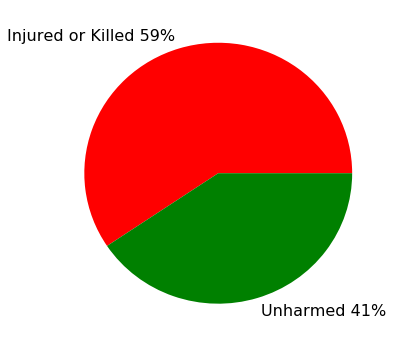

In [11]:
plt.figure(figsize=(6, 6))
patches, texts = plt.pie([total_incidents - zero_killed_or_injured, zero_killed_or_injured], 
                                     labels=['Injured or Killed 59%', 'Unharmed 41%'], colors=['r', 'g'])
texts[0].set_fontsize(16)
texts[1].set_fontsize(16)

In [12]:
Markdown("""
### In 1 of {:.0f} incident there is killed person and 1 of {:.0f} with injured.
""".format(round(1 / df['n_killed'].mean()), round(1 / df['n_injured'].mean())))


### In 1 of 4 incident there is killed person and 1 of 2 with injured.


In [13]:
temp = df['n_killed'].value_counts()\
.reset_index().rename(columns={'index': 'n_killed', 'n_killed': 'count'}).sort_values(by='n_killed')
temp['freq'] = temp['count'] / total_incidents
temp.loc[temp['freq'] >= 0.0001, ['n_killed', 'freq']]

,n_killed,freq
0,0,0.775356
1,1,0.202089
2,2,0.019209
3,3,0.002483
4,4,0.000580
5,5,0.000171


In [14]:
Markdown("""
### Mass shooting (more or equal than 4 killed) is rare event it happend 1 in {:.0f} inidents
""".format( 1 / temp.loc[temp['n_killed'] >= 4, 'freq'].sum()))


### Mass shooting (more or equal than 4 killed) is rare event it happend 1 in 1158 inidents


In [15]:
temp = (df['n_injured'] + df['n_killed']).value_counts().reset_index()\
.rename(columns={'index': 'n_injured_or_killed', 0: 'count'}).sort_values(by='n_injured_or_killed')
temp['freq'] = temp['count'] / total_incidents
temp.loc[temp['freq'] >= 0.001, ['n_injured_or_killed', 'freq']]

,n_injured_or_killed,freq
1,0,0.405909
0,1,0.484936
2,2,0.082586
3,3,0.017799
4,4,0.005591
5,5,0.001807


In [16]:
Markdown("""
### The most probable situation is where zero or one person injured or killed. \
Over {:.2f}% of all insidents have less or equal than 2 injured or killed person.
""".format(temp.loc[temp['n_injured_or_killed'] <= 2, 'freq'].sum()))


### The most probable situation is where zero or one person injured or killed. Over 0.97% of all insidents have less or equal than 2 injured or killed person.


In [17]:
df['year'].value_counts()

2017    61401
2016    58763
2015    53579
2014    51854
2018    13802
2013      278
Name: year, dtype: int64

### It seems what amout of cases with guns increasing (if we drop 2013, 2018 because we don't have full data on them)

In [18]:
df.loc[(df['n_killed'] == 0) & (df['n_injured']  == 0), 'date'].dt.year.value_counts()

2017    24272
2014    23700
2016    22224
2015    21121
2018     5970
Name: date, dtype: int64

In [19]:
df.loc[~((df['n_killed'] == 0) & (df['n_injured']  == 0)), 'date'].dt.year.value_counts()

2017    37129
2016    36539
2015    32458
2014    28154
2018     7832
2013      278
Name: date, dtype: int64

### Amout of cases with injured people is also increasing

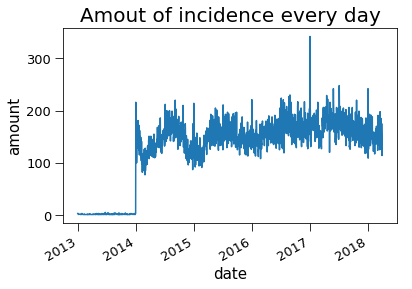

In [20]:
ax = df.groupby(by='date')['state'].count().plot()
ax.set_ylabel('amount', fontdict={'fontsize': 15})
ax.set_xlabel('date', fontdict={'fontsize': 15})
ax.tick_params(labelsize=13, length=8)
text = plt.title('Amout of incidence every day')
text.set_fontsize(20)

### 2013 is almost empty and should be ignored.

In [21]:
df.drop(df.loc[df['year'] == 2013].index, axis=0, inplace=True)

In [22]:
for year in range(2014, 2019):
    print('In {} {} unique websites were used'\
          .format(year, df.loc[df['year'] == year, 'source_url']\
                  .str.split('//').str.get(1).str.replace('^www.','').str.split('/').str.get(0).nunique()))

In 2014 2001 unique websites were used
In 2015 1900 unique websites were used
In 2016 2197 unique websites were used
In 2017 2429 unique websites were used
In 2018 1450 unique websites were used


In [23]:
for year in range(2014, 2019):
    print('In {} {} websites with more than 1 incident are used'\
          .format(year, (df.loc[df['year'] == year, 'source_url'].str.split('//')\
                  .str.get(1).str.replace('www.','').str.split('/').str.get(0)\
                  .value_counts() > 1).sum()))

In 2014 1310 websites with more than 1 incident are used
In 2015 1256 websites with more than 1 incident are used
In 2016 1515 websites with more than 1 incident are used
In 2017 1715 websites with more than 1 incident are used
In 2018 1026 websites with more than 1 incident are used


### The amount of website where data is found is also increasing with time. 

In [24]:
amount = np.array([51854, 53579, 58763, 61401])
year = np.array([2001, 1900, 2197, 2429])
stats.pearsonr(amount, year)

(0.9286527706898371, 0.07134722931016292)

In [25]:
amount = np.array([51854, 53579, 58763, 61401])
year = np.array([1310, 1256, 1515, 1715])
stats.pearsonr(amount, year)

(0.9534795845489521, 0.046520415451047896)

### In both cases they highly correlated. But it doesn't mean that increasing of gun involved incidents can be explained by increasing of data sources.

# Work on participant features

In [26]:
for i in range(6):
    print('Part of incident with at least {1} person involved is {0}'.format(round(df['participant_age'].str.split('\|+').str.get(i).str.replace('[\d]*:+', '').notna().sum()\
    / df['participant_age'].notna().sum(), 2), i+1))

Part of incident with at least 1 person involved is 1.0
Part of incident with at least 2 person involved is 0.34
Part of incident with at least 3 person involved is 0.1
Part of incident with at least 4 person involved is 0.03
Part of incident with at least 5 person involved is 0.01
Part of incident with at least 6 person involved is 0.0


In [27]:
# n_people is amount of people we try to extract from participant's features
# n_people <= 5 is 97% of dataset
n_people = 5
for person_number in range(n_people):
    df['age_{}'.format(person_number)] = df['participant_age'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    df['gender_{}'.format(person_number)] = df['participant_gender'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')

In [28]:
df['age_0'].dropna().astype('int').max(), df['age_0'].dropna().astype('int').min()

(311, 0)

In [29]:
# put restriction on age: 0 <= age <= 100
for person_number in range(n_people):
    df.loc[df['age_{}'.format(person_number)].astype('float') >= 100, 'age_{}'.format(person_number)] = 100
    df.loc[df['age_{}'.format(person_number)].astype('float') <= 0, 'age_{}'.format(person_number)] = 0

In [30]:
df['gender_0'].dropna().value_counts()

Male            177745
Female           25308
Male, female         1
Name: gender_0, dtype: int64

In [31]:
# put restriction on gender: gender is Male or Female
for person_number in range(n_people):
    df.loc[~df['gender_{}'.format(person_number)]\
           .isin(['Male', 'Female', np.NAN]), 'gender_{}'.format(person_number)] = 'Male'

In [32]:
list_noncense = ['Killed, Arrested', 'Injured, Unharmed', 'Injured, Unharmed, Arrested', 'Killed, Unharmed',
                 'Killed, Injured', 'Killed, Unharmed, Arrested']

In [33]:
for person_number in range(n_people):
    df['type_{}'.format(person_number)] = df['participant_type'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    df['status_{}'.format(person_number)] = df['participant_status'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')

In [34]:
for person_number in range(n_people):
    df.drop(df.loc[df['status_{}'.format(person_number)].isin(list_noncense)].index, axis=0, inplace=True)

In [35]:
# Some of category of incidents
description = ['Home Invasion', 'Armed robbery', 'Domestic Violence', 'Officer', 'Road rage', 'Sex crime', 
               'TSA Action', 'Car-jacking', 'Animal', 'Accidental', 'Drive-by']

total = df['incident_characteristics'].notna().sum()
informative = df['incident_characteristics'].str.contains('|'.join(description)).sum()

Markdown("""
### There are {} description and only part of them {} is usefull.
""".format(total, informative))


### There are 238931 description and only part of them 85508 is usefull.


In [36]:
value = []
for desc in description:
    value.append(df['incident_characteristics'].str.contains(desc).sum())

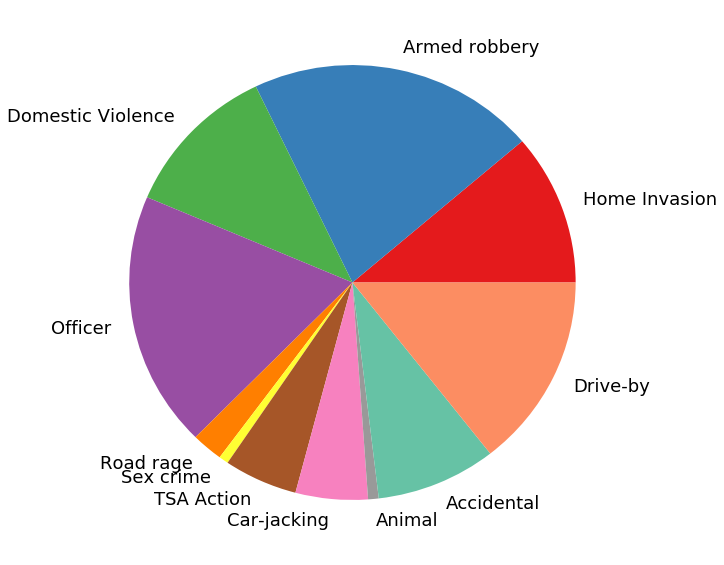

In [37]:
plt.figure(figsize=(10, 10))
col = plt.cm.Set1.colors + plt.cm.Set2.colors
patches, texts = plt.pie(value, labels=description, colors=col[:len(value)])
[text.set_fontsize(18) for text in texts];

In [38]:
value_k = []
value_i = []

for desc in description:
    value_k.append(df.loc[df['incident_characteristics'].str.contains(desc) == True, 'n_killed'].mean())
    value_i.append(df.loc[df['incident_characteristics'].str.contains(desc) == True, 'n_injured'].mean())

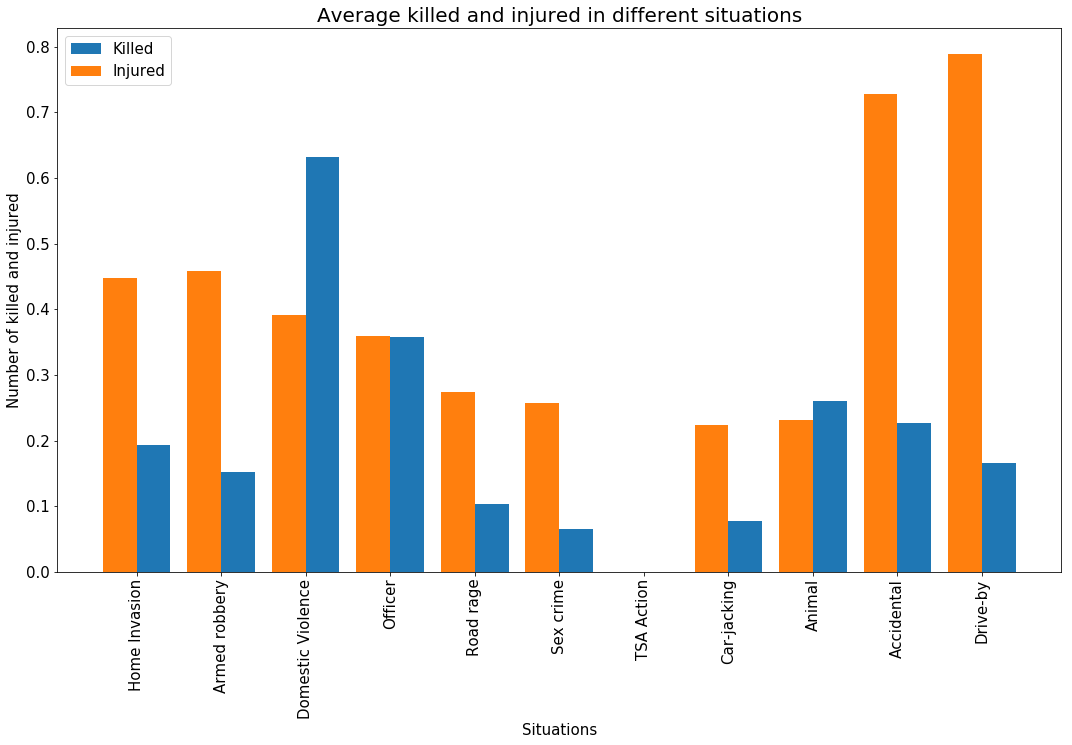

In [39]:
plt.figure(figsize=(18, 10))
plt.bar(np.arange(len(description)) + 0.2, value_k, width=0.4, label='Killed', tick_label=description)
plt.bar(np.arange(len(description)) - 0.2, value_i, width=0.4, label='Injured')

plt.legend(fontsize=15)
plt.title('Average killed and injured in different situations', fontdict={'fontsize' : 20})
plt.xticks(np.arange(len(description)), rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Situations', fontsize=15)
plt.ylabel('Number of killed and injured', fontsize=15);

### The most dangerous situation are domestic violence and with involving police officer. TSA is Transportation Security Administration and mostly works in airports. This is explain why they almost doesn't have killed or injured person in their incidents.

In [40]:
value_m = []
for desc in description:
    temp = df.loc[df['incident_characteristics'].str.contains(desc) == True, :]\
    .groupby(by='month')['date'].count()
    value_m.append(temp / temp.max())

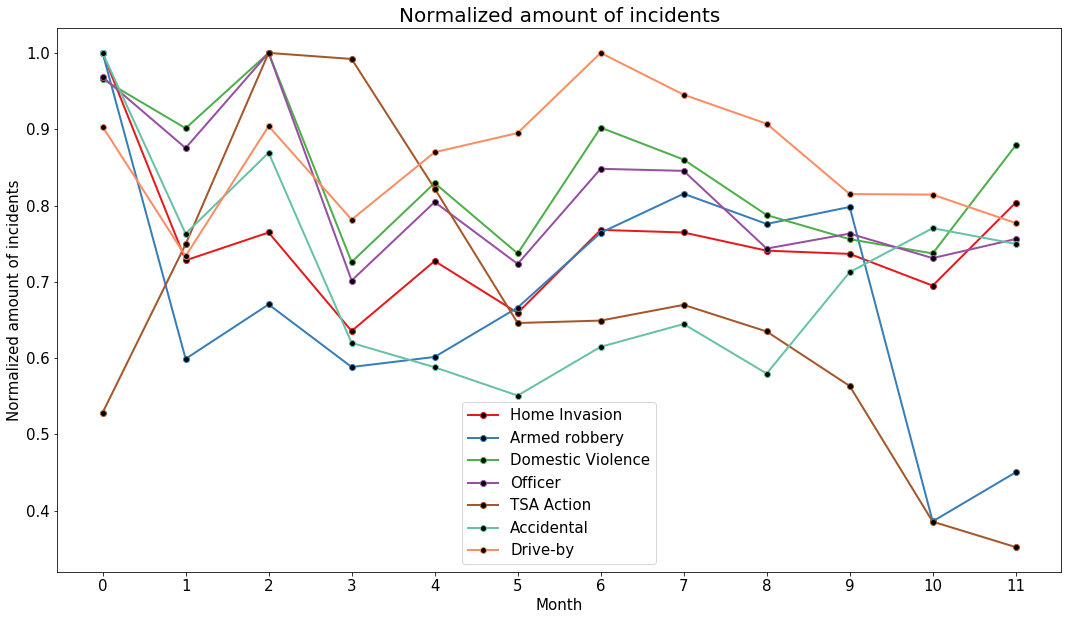

In [41]:
fig = plt.figure(figsize=(18, 10))

skip_list = ['Animal', 'Sex crime', 'Road rage', 'Car-jacking']
for i, desc in enumerate(description):
    if desc in skip_list:
        continue
    plt.plot(range(value_m[i].shape[0]), value_m[i].values, label=desc, 
             c=col[i], linewidth=2, marker='o', markerfacecolor='k')
    
plt.legend(fontsize=15)
plt.title('Normalized amount of incidents', fontdict={'fontsize' : 20})
plt.xticks(np.arange(12), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Normalized amount of incidents', fontsize=15);

### There isn't clear dependence. Almost all of them have maximum in January. Again TSA differ from all other general situations.

In [42]:
value_w = []
for desc in description:
    temp = df.loc[df['incident_characteristics'].str.contains(desc) == True, :]\
    .groupby(by='weekday')['date'].count()
    value_w.append(temp / temp.max())

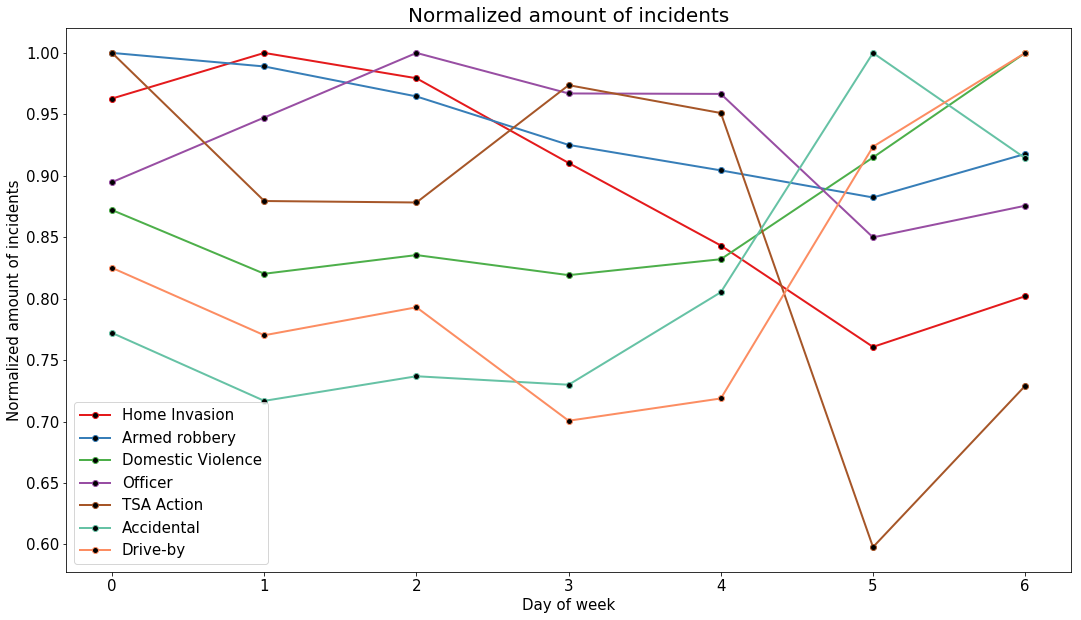

In [43]:
fig = plt.figure(figsize=(18, 10))

skip_list = ['Animal', 'Sex crime', 'Road rage', 'Car-jacking']
for i, desc in enumerate(description):
    if desc in skip_list:
        continue
    plt.plot(range(value_w[i].shape[0]), value_w[i].values, label=desc, 
             c=col[i], linewidth=2, marker='o', markerfacecolor='k')
    
plt.legend(fontsize=15)
plt.title('Normalized amount of incidents', fontdict={'fontsize' : 20})
plt.xticks(np.arange(7), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Day of week', fontsize=15)
plt.ylabel('Normalized amount of incidents', fontsize=15);

### There are some reasonable stuff. Domestic violence happen more often on weekends when everybody home together full day long. Home invasions happen less on weekends when owners are expected.

# Work on gun_type and n_guns_involved features

In [44]:
(df['n_guns_involved'].value_counts() / df['n_guns_involved'].value_counts().sum()).head(3).sum()

0.9773100601351256

### Incidents with 3 or less gun involved are about 97% (not including NAN) of our dataset, so it is ok to extract information of this amount of gun from feature gun_type 

In [45]:
df.gun_type.isnull().sum()

99239

In [46]:
n_gun = 3
for gun in range(n_gun):
    df['gun_type_{}'.format(gun)] = df['gun_type'].str.split('\|*')\
    .str.get(gun).str.replace('[\d*]:+', '')

In [47]:
def freq_dict(df, feature_name='gun_type', n=n_gun):
    temp_dict = {}
    for gun in range(n):
        _ = df[feature_name + '_{}'.format(gun)].value_counts().to_dict()
        if len(temp_dict) == 0:
            temp_dict = _
        else:
            for (k, v) in _.items():
                if k in temp_dict:
                    temp_dict[k] += _[k]
                else:
                    temp_dict[k] = _[k] 
    return temp_dict

temp_dict = freq_dict(df)

In [48]:
temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp

,freq
Unknown,105007
Handgun,20948
9mm,6174
Rifle,3594
Shotgun,3547
22 LR,3133
40 SW,2613
380 Auto,2316
45 Auto,2239
38 Spl,1748


### There isn't information about gun type in most of incident, but we will analysis what we have.

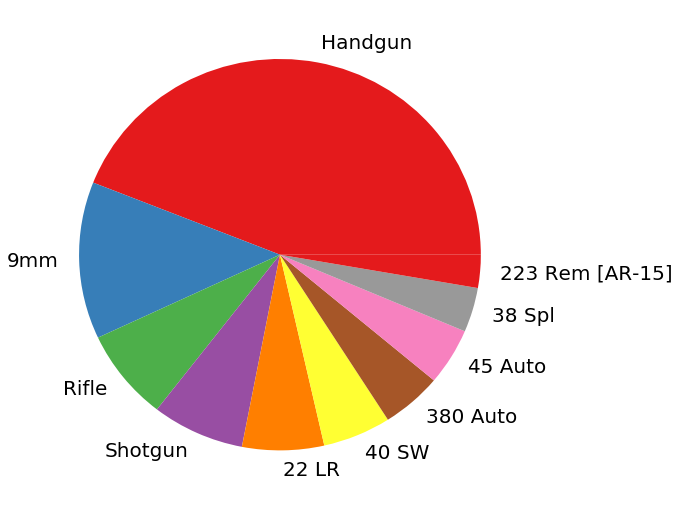

In [49]:
temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp = temp.reset_index().head(11)
temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
plt.figure(figsize=(9, 9))
patches, texts = plt.pie(x=temp['freq'], labels=temp['index'], colors=plt.cm.Set1.colors[:temp['index'].shape[0]])

[text.set_fontsize(20) for text in texts];

### The most incidents is happened with handgun.

In [50]:
amount_of_killed = 4
temp_list_with_dict_k = [freq_dict(df.loc[df['n_killed'] == i]) for i in range(amount_of_killed)] \
+ [freq_dict(df.loc[df['n_killed'] > amount_of_killed])]

temp_list_with_str_k = ['With {} dead | {} incidents'\
                      .format(i+1, df.loc[df['n_killed'] == i].shape[0]) for i in range(amount_of_killed)]\
+ ['With > {} dead | {} incidents'\
   .format(amount_of_killed, df.loc[df['n_killed'] == amount_of_killed].shape[0])] 


amount_of_injured = 4
temp_list_with_dict_i = [freq_dict(df.loc[df['n_injured'] == i]) for i in range(amount_of_injured)] \
+ [freq_dict(df.loc[df['n_injured'] > amount_of_injured])]

temp_list_with_str_i = ['With {} injured | {} incidents'\
                      .format(i+1, df.loc[df['n_injured'] == i].shape[0]) for i in range(amount_of_injured)]\
+ ['With > {} injured | {} incidents'\
   .format(amount_of_injured, df.loc[df['n_injured'] == amount_of_injured].shape[0])] 

n_casulties = 4
temp_list_with_dict_c = [freq_dict(df.loc[df['n_killed_injured'] == i]) for i in range(n_casulties)] \
+ [freq_dict(df.loc[df['n_killed_injured'] > n_casulties])]

temp_list_with_str_c = ['With {} killed or injured | {} incidents'\
                      .format(i+1, df.loc[df['n_killed_injured'] == i].shape[0]) for i in range(n_casulties)]\
+ ['With > {} killed or injured | {} incidents'\
   .format(n_casulties, df.loc[df['n_killed_injured'] == n_casulties].shape[0])] 

In [51]:
# map wepon to color
temp_dict = freq_dict(df)
temp_color = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp_color = temp_color.reset_index().head(21)
temp_color.drop(temp_color.loc[(temp_color['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
temp_color['color'] = (plt.cm.Set1.colors + plt.cm.Dark2.colors + plt.cm.tab10.colors)[:temp_color['index'].shape[0]]
temp_color.drop(['freq'], axis=1, inplace=True)

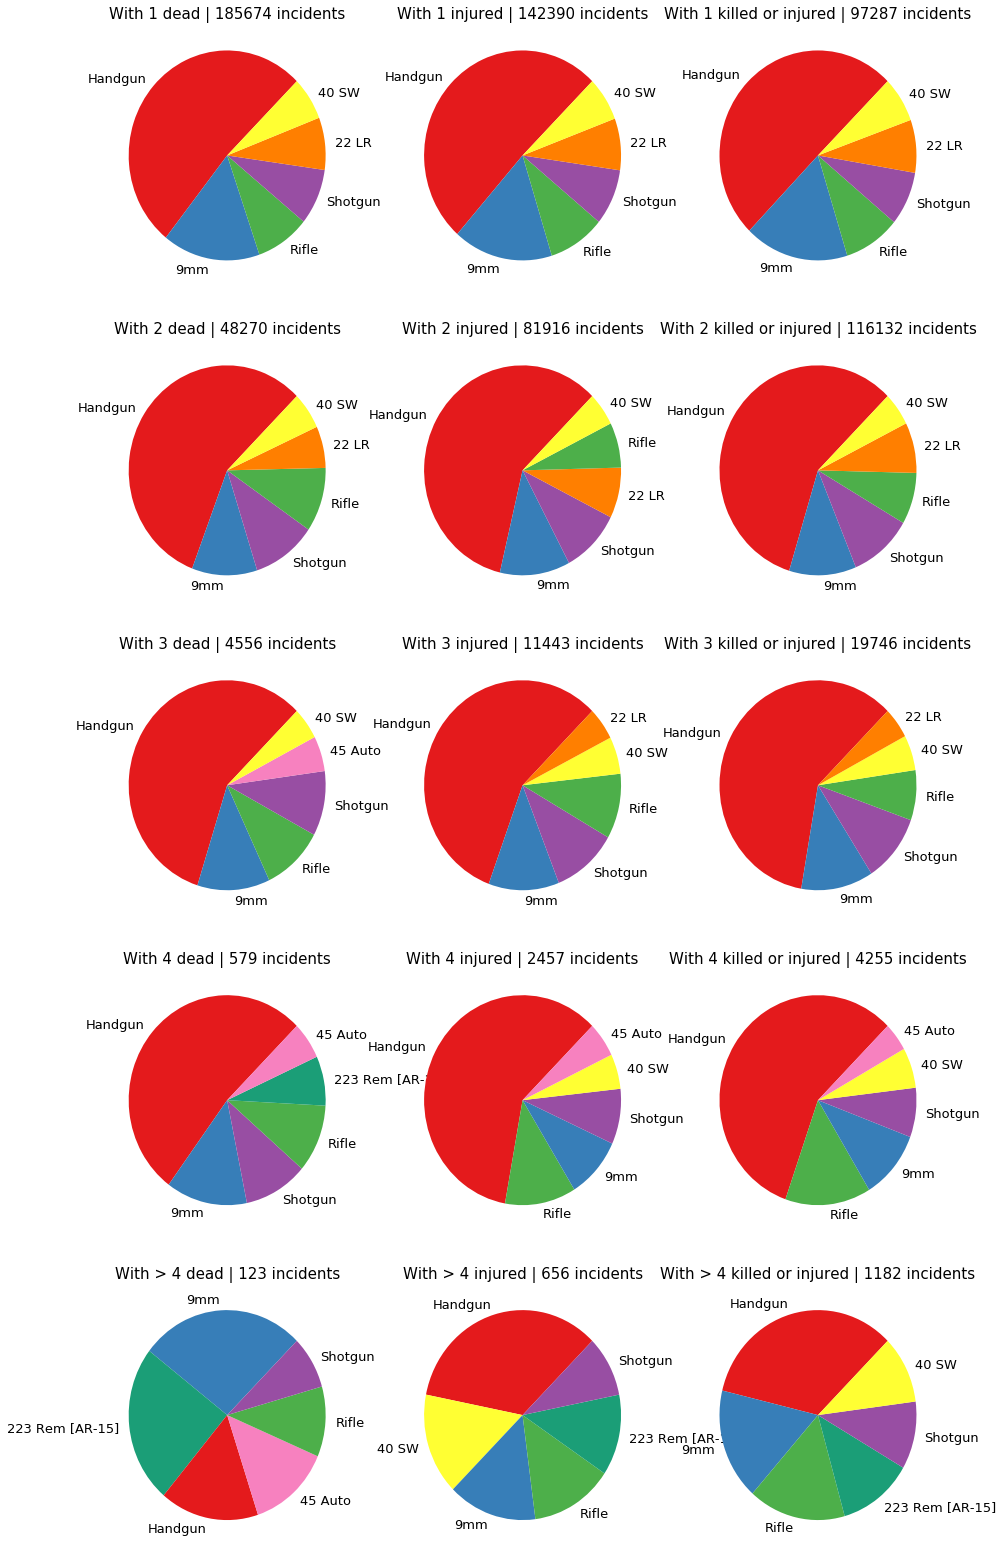

In [52]:
fig, ax = plt.subplots(len(temp_list_with_dict_k), 3)
fig.set_figheight(7 * amount_of_killed)
fig.set_figwidth(15)

for i, temp_dict in enumerate(temp_list_with_dict_k):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 0].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 0].set_title(temp_list_with_str_k[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];
    
for i, temp_dict in enumerate(temp_list_with_dict_i):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 1].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 1].set_title(temp_list_with_str_i[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];
    
for i, temp_dict in enumerate(temp_list_with_dict_c):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 2].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 2].set_title(temp_list_with_str_c[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];

### In mass shooting part of handguns is decreasing.

In [53]:
# There are much more male than female
freq_dict(df, 'gender', 5)

{'Female': 42305, 'Male': 304648}

In [54]:
# ratio
304734 / 42234

7.215371501633755

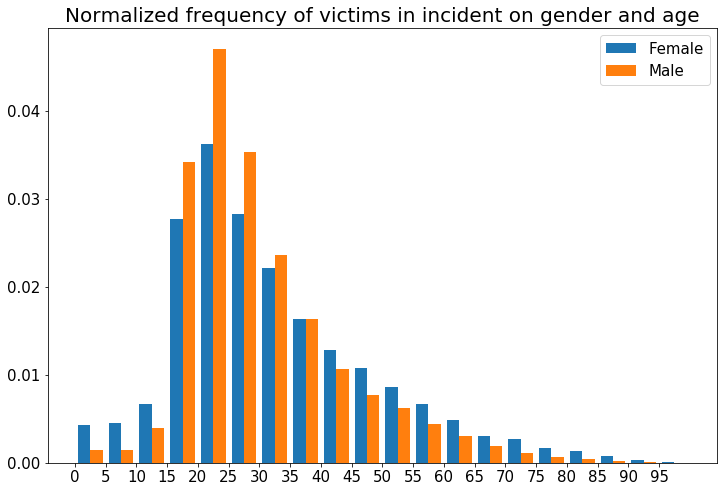

In [55]:
fig = plt.figure(figsize=(12, 8))
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
plt.hist([temp, temp2], bins=20, normed=True, label=['Female', 'Male']);
plt.legend(fontsize=15)
plt.title('Normalized frequency of victims in incident on gender and age', fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, 100, step=5), fontsize=15);
plt.yticks(fontsize=15);

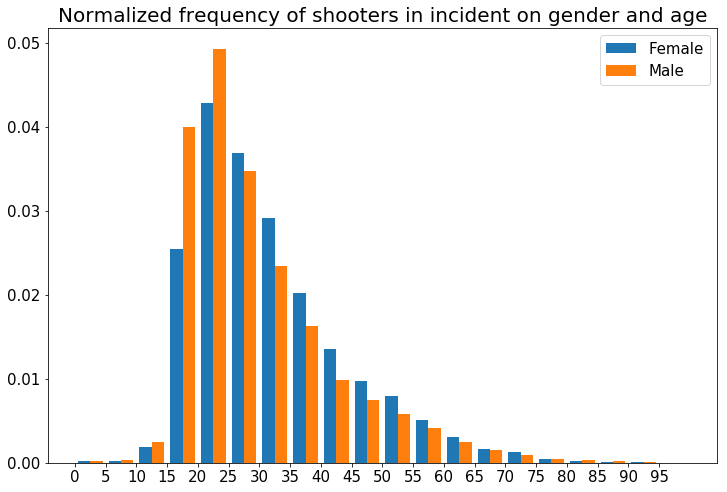

In [56]:
fig = plt.figure(figsize=(12, 8))
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
plt.hist([temp, temp2], bins=20, normed=True, label=['Female', 'Male']);
plt.legend(fontsize=15)
plt.title('Normalized frequency of shooters in incident on gender and age', fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, 100, step=5), fontsize=15);
plt.yticks(fontsize=15);

### There isn't any different between victims and shooters in age distribution. Also their mean age is almost the same and isn't depend on gender or role in incident.

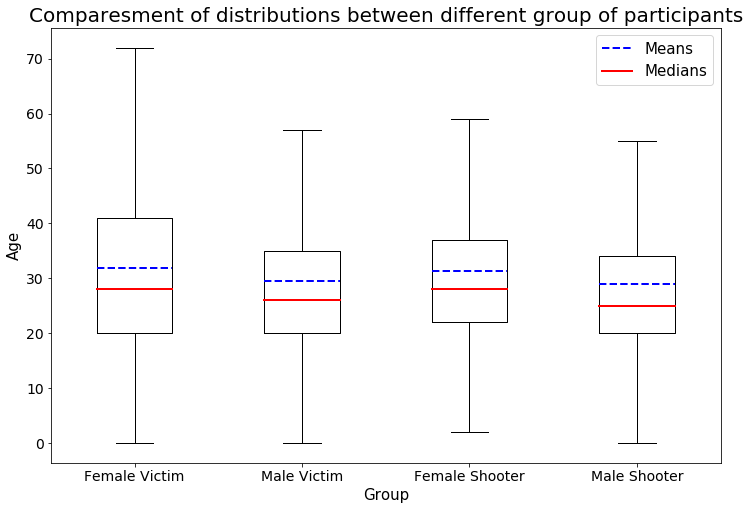

In [57]:
temp1 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp3 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp4 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])

fig = plt.figure(figsize=(12, 8))
plt.title('Comparesment of distributions between different group of participants', fontsize=20)
lines = plt.boxplot([temp1, temp2, temp3, temp4], 
            labels=['Female Victim', 'Male Victim', 'Female Shooter', 'Male Shooter'], showfliers=False,
            showmeans=True, meanline=True)

[i.set_linewidth(2) for i in lines['means']]
[i.set_color('blue') for i in lines['means']]
[i.set_linewidth(2) for i in lines['medians']]
[i.set_color('red') for i in lines['medians']]

plt.legend((lines['means'][0], lines['medians'][0]), ['Means', 'Medians'], fontsize=15)
plt.ylabel('Age', fontsize=15)
plt.xlabel('Group', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
del temp1, temp2, temp3, temp4

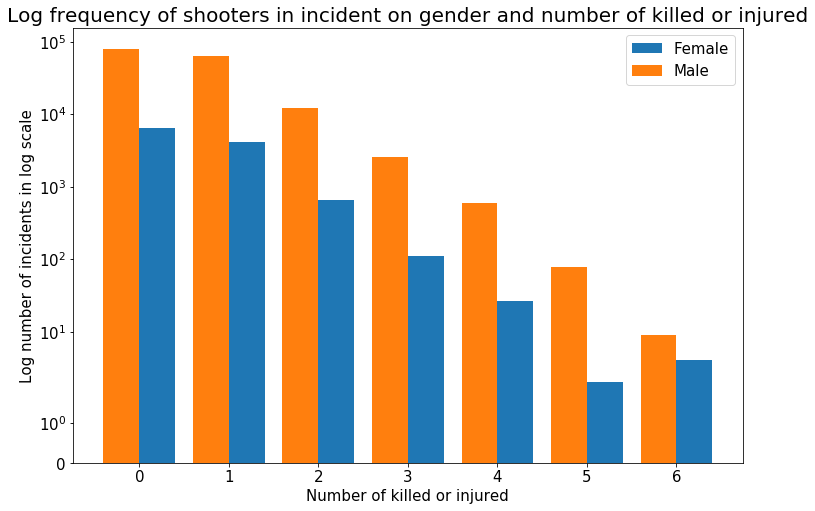

In [58]:
fig = plt.figure(figsize=(12, 8))
male =[]
female = []
n_k = 7
for k in range(n_k):
    temp = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect') & \
                       (df['n_killed_injured'] == k), 'n_killed_injured'].shape[0] for i in range(n_people)])
    temp2 = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect') & \
                    (df['n_killed_injured'] == k), 'n_killed_injured'].shape[0] for i in range(n_people)])
    female.append(temp)
    male.append(temp2)

plt.yscale('symlog')
plt.bar(np.arange(n_k) + 0.2, female, width=0.4, label='Female')
plt.bar(np.arange(n_k) - 0.2, male, width=0.4, label='Male')
plt.legend(fontsize=15)
plt.title('Log frequency of shooters in incident on gender and number of killed or injured', 
          fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, n_k, step=1), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of killed or injured', fontsize=15)
plt.ylabel('Log number of incidents in log scale', fontsize=15);

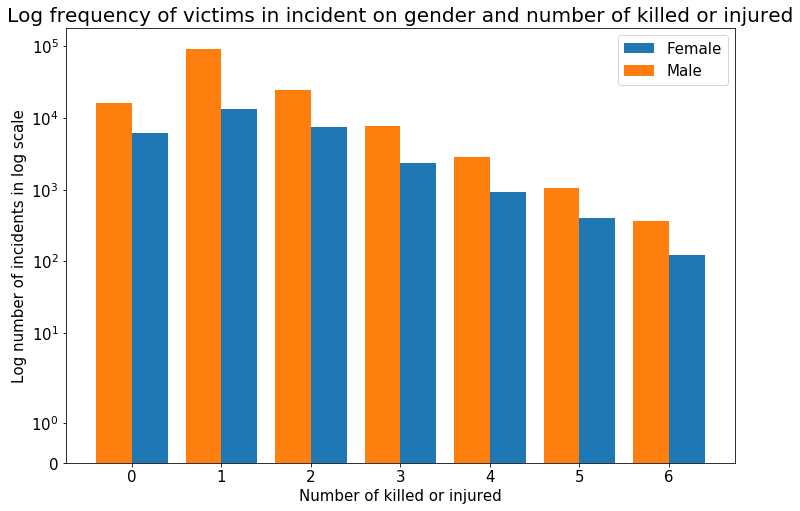

In [59]:
fig = plt.figure(figsize=(12, 8))
male =[]
female = []
n_k = 7
for k in range(n_k):
    temp = sum([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim') & \
                       (df['n_killed_injured'] == k), 'n_killed_injured'].shape[0] for i in range(n_people)])
    temp2 = sum([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim') & \
                    (df['n_killed_injured'] == k), 'n_killed_injured'].shape[0] for i in range(n_people)])
    female.append(temp)
    male.append(temp2)

plt.yscale('symlog')
plt.bar(np.arange(n_k) + 0.2, female, width=0.4, label='Female')
plt.bar(np.arange(n_k) - 0.2, male, width=0.4, label='Male')
plt.legend(fontsize=15)
plt.title('Log frequency of victims in incident on gender and number of killed or injured', 
          fontdict={'fontsize' : 20})
plt.xticks(np.arange(0, n_k, step=1), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of killed or injured', fontsize=15)
plt.ylabel('Log number of incidents in log scale', fontsize=15);
ax = fig.get_axes()[0]

### The dependences is linear in log scale, so amount of incidents with increasing number of killed or injured are decaying exponentially.

In [60]:
df['status_0'].value_counts()

Injured               85770
Killed                50651
Unharmed, Arrested    35174
Unharmed              34428
Arrested               3819
Injured, Arrested      1789
Name: status_0, dtype: int64

In [61]:
status_k = ['Killed']
status_i = ['Injured', 'Injured, Arrested']
status_u = ['Unharmed, Arrested', 'Unharmed', 'Arrested']

In [62]:
def frequency_incidents(df, gender, rolle, status_group, n_people=n_people):
    return sum([df.loc[(df['gender_%s' % i] == gender) & (df['type_%s' % i] == rolle) & \
                         (df['status_%s' % i].isin(status_group)), 'n_killed_injured'].shape[0] \
                for i in range(n_people)])

In [63]:
temp_f_k_v = frequency_incidents(df, 'Female', 'Victim', status_k)
temp_m_k_v = frequency_incidents(df, 'Male', 'Victim', status_k)
temp_f_i_v = frequency_incidents(df, 'Female', 'Victim', status_i)
temp_m_i_v = frequency_incidents(df, 'Male', 'Victim', status_i)
temp_f_u_v = frequency_incidents(df, 'Female', 'Victim', status_u)
temp_m_u_v = frequency_incidents(df, 'Male', 'Victim', status_u)

temp_f_k_s = frequency_incidents(df, 'Female', 'Subject-Suspect', status_k)
temp_m_k_s = frequency_incidents(df, 'Male', 'Subject-Suspect', status_k)
temp_f_i_s = frequency_incidents(df, 'Female', 'Subject-Suspect', status_i)
temp_m_i_s = frequency_incidents(df, 'Male', 'Subject-Suspect', status_i)
temp_f_u_s = frequency_incidents(df, 'Female', 'Subject-Suspect', status_u)
temp_m_u_s = frequency_incidents(df, 'Male', 'Subject-Suspect', status_u)

l_f = [temp_f_k_v, temp_f_k_s, temp_f_i_v, temp_f_i_s, temp_f_u_v, temp_f_u_s]
f_max = max(l_f)

l_m = [temp_m_k_v, temp_m_k_s, temp_m_i_v, temp_m_i_s, temp_m_u_v, temp_m_u_s]
m_max = max(l_m)

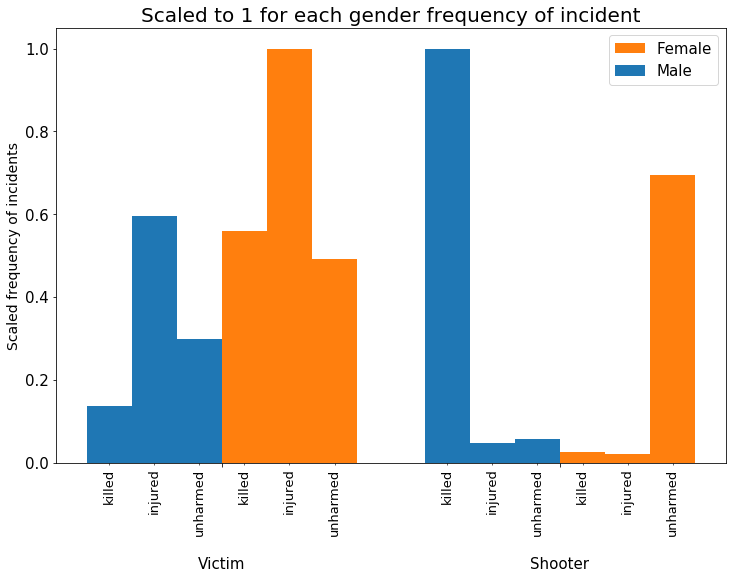

In [64]:
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
orange = (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)

fig = plt.figure(figsize=(12, 8))
plt.bar(np.arange(0, 6, 3) + 0.2, [temp_f_k_v / f_max, temp_f_k_s / f_max], width=0.4, label='Female', color=orange)
plt.bar(np.arange(0, 6, 3) + 0.6, [temp_f_i_v / f_max, temp_f_i_s / f_max], width=0.4, color=orange)
plt.bar(np.arange(0, 6, 3) + 1, [temp_f_u_v / f_max, temp_f_u_s / f_max], width=0.4, color=orange)

plt.bar(np.arange(0, 6, 3) - 0.2, [temp_m_k_v / m_max, temp_m_k_s / m_max], width=0.4, label='Male', color=blue)
plt.bar(np.arange(0, 6, 3) - 0.6, [temp_m_i_v / m_max, temp_m_i_s / m_max], width=0.4, color=blue)
plt.bar(np.arange(0, 6, 3) - 1, [temp_m_u_v / m_max, temp_m_u_s / m_max], width=0.4, color=blue)

plt.legend(fontsize=15)
plt.title('Scaled to 1 for each gender frequency of incident', fontdict={'fontsize' : 20})
ax = fig.get_axes()[0]
ax.xaxis.set_minor_locator(ticker.FixedLocator(([-1, -0.6, -0.2, 0.2, 0.6, 1, 2, 2.4, 2.8, 3.2, 3.6, 4])))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter((['killed', 'injured', 'unharmed'] * 4)))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, fontsize=13)

ax.xaxis.set_major_locator(ticker.FixedLocator(([0, 3])))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((['Victim', 'Shooter'])))
ax.xaxis.get_majorticklabels()[0].set_position((0, -0.2))
ax.xaxis.get_majorticklabels()[1].set_position((3, -0.2))
plt.setp(ax.xaxis.get_majorticklabels(), fontsize=15)
plt.setp(ax.yaxis.get_majorticklabels(), fontsize=15)
ax.set_ylabel('Scaled frequency of incidents', fontsize=14);

### The distribution between gender is pretty different, especially in role of shooter. Female shooter has much more chances to be unharmed, while male shooter most likely to be killed.

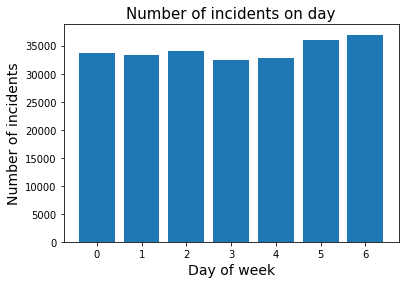

In [65]:
week = df['weekday'].value_counts().reset_index().rename(columns={'index': 'weekday', 'weekday': 'count'})
ax = plt.axes()
plt.bar(week['weekday'], week['count']);

ax.set_title('Number of incidents on day', fontdict={'fontsize': 15})
ax.set_xlabel('Day of week', fontsize=14)
ax.set_ylabel('Number of incidents', fontsize=14);

### There is a little bit more incidents on weekends. 

In [66]:
def check_season(week):
#     year = int(date.dt.year)
    if week >= 15 and week < 27:
        return 'spring'
    if week >= 27 and week < 39:
        return 'summer'
    if week >= 39 and week < 51:
        return 'fall'
    else:
        return 'winter'
df['season'] = df['date'].dt.weekofyear.apply(check_season)

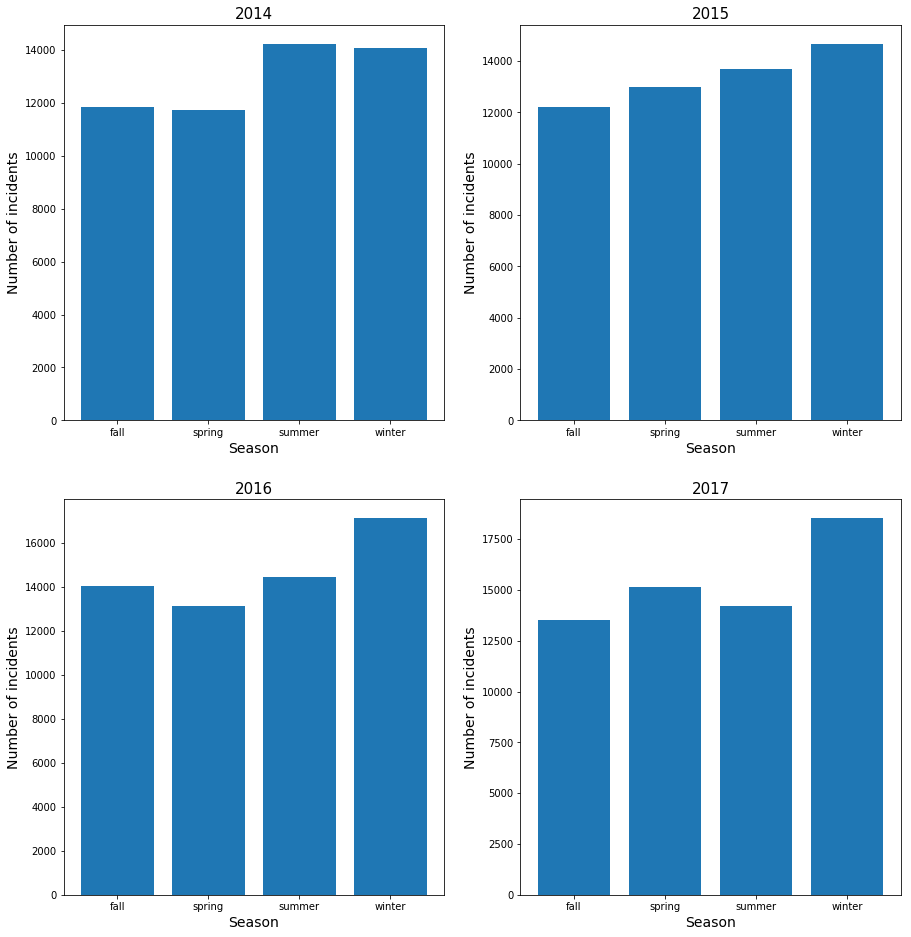

In [67]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(4 * amount_of_killed)
fig.set_figwidth(15)

for i, year in enumerate([2014, 2015, 2016, 2017]):
    season = df.loc[df['year'] == year, 'season'].value_counts()\
    .reset_index().rename(columns={'index': 'season', 'season': 'n_incidents'})

    if i >= 2:
        ax[1, i % 2].set_title(year, fontdict={'fontsize': 15})
        ax[1, i % 2].set_xlabel('Season', fontsize=14)
        ax[1, i % 2].set_ylabel('Number of incidents', fontsize=14)
        ax[1, i % 2].bar(season['season'].values, season['n_incidents'].values);
    else:
        ax[0, i].set_title(year, fontdict={'fontsize': 15})
        ax[0, i].set_xlabel('Season', fontsize=14)
        ax[0, i].set_ylabel('Number of incidents', fontsize=14)
        ax[0, i].bar(season['season'].values, season['n_incidents'].values);

### The winter is a dominant in number of incidents. Summer is seemed to be violent season too, but it's not true about 2017. Let's consider smaller dateframe.

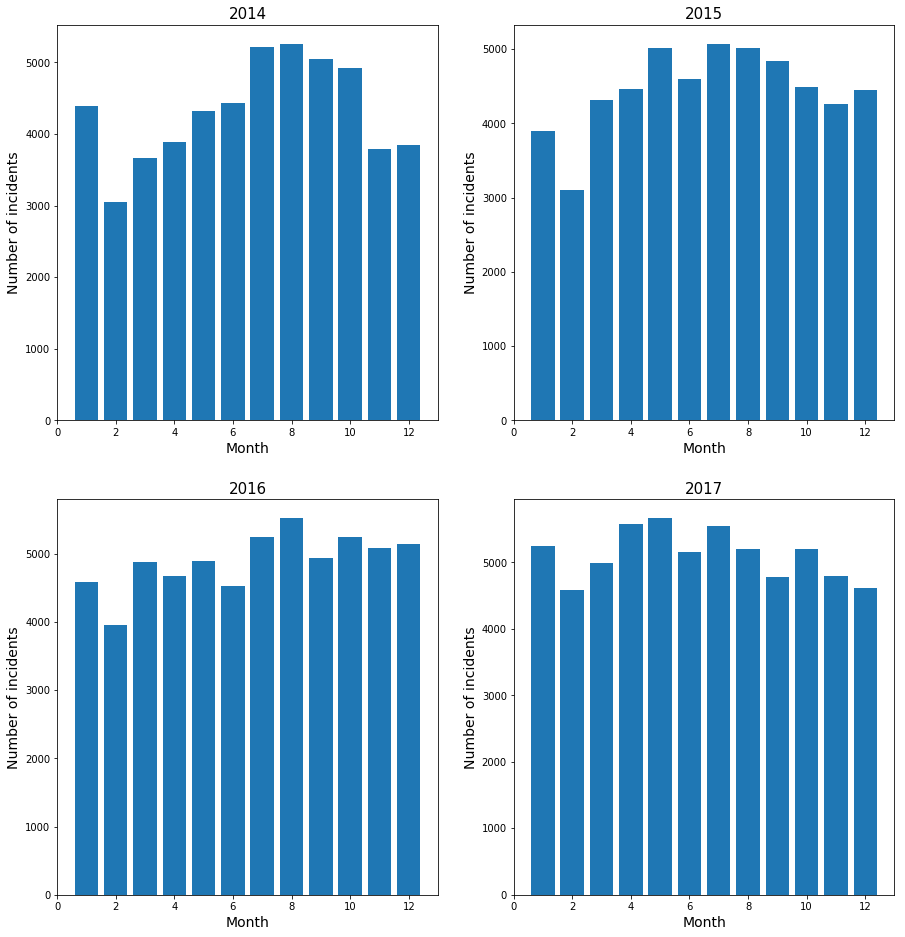

In [68]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(4 * amount_of_killed)
fig.set_figwidth(15)

for i, year in enumerate([2014, 2015, 2016, 2017]):
    month = df.loc[df['year'] == year, 'month'].value_counts()\
    .reset_index().rename(columns={'index': 'month', 'month': 'count'})
    month = month.sort_values(by='month')
    if i >= 2:
        ax[1, i % 2].set_title(year, fontdict={'fontsize': 15})
        ax[1, i % 2].set_xlabel('Month', fontsize=14)
        ax[1, i % 2].set_ylabel('Number of incidents', fontsize=14)
        ax[1, i % 2].bar(month['month'], month['count'], label=year);
    else:
        ax[0, i].set_title(year, fontdict={'fontsize': 15})
        ax[0, i].set_xlabel('Month', fontsize=14)
        ax[0, i].set_ylabel('Number of incidents', fontsize=14)
        ax[0, i].bar(month['month'], month['count']);

### There isn't a clear dependence. It seems that there are more incidents during summer, but it's not true about 2017. January has bigger amount of incidents than February. It can be because of holidays. 

In [69]:
holiday_names = ['Martin Luther King Jr. Day', 'President\'s Day', 'Memorial Day', 'Independence Day', 
                 'Labor Day', 'Colombus Day', 'Veterans Day', 'Thanksgiving', 'Christmas Day', 'New Years Day']

holiday_2017 = ['2017-01-16', '2017-02-20', '2017-05-29', '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10', 
                '2017-11-23', '2017-12-25', '2017-01-01']

holiday_2016 = ['2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', 
                '2016-11-24', '2016-12-25', '2016-01-01']

holiday_2015 = ['2015-01-19', '2015-02-16', '2015-05-25', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', 
                '2015-11-26', '2015-12-25', '2015-01-01']

holiday_2014 = ['2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', 
                '2014-11-27', '2014-12-25', '2014-01-01']

In [70]:
def holiday_vs_casual(df, stat):
    # Calculate stat on holiday, one day before and after it
    # And same statistic for 3 days before and after holiday
    temp_year = [] 
    for holidays in [holiday_2014, holiday_2015, holiday_2016, holiday_2017]:
        temp = []
        for holiday in holidays:
            dates_h = pd.date_range(pd.to_datetime(holiday) - pd.to_timedelta('1 days'), 
                                    pd.to_datetime(holiday) + pd.to_timedelta('1 days'), freq='D')

            dates = pd.date_range(pd.to_datetime(holiday) + pd.to_timedelta('2 days'), 
                                  pd.to_datetime(holiday) + pd.to_timedelta('4 days'), freq='D')\
            .append(pd.date_range(pd.to_datetime(holiday) - pd.to_timedelta('4 days'), 
                                  pd.to_datetime(holiday) - pd.to_timedelta('2 days'), freq='D'))
            
            if stat == 'count':
                temp.append(df.loc[df['date'].isin(dates_h), 'date'].value_counts().sum()\
                            - df.loc[df['date'].isin(dates), 'date'].value_counts().sum() / 2)
            if stat == 'injured':
                temp.append(df.loc[df['date'].isin(dates_h), 'n_injured'].sum()\
                            - df.loc[df['date'].isin(dates), 'n_injured'].sum() / 2)
            if stat == 'killed':
                temp.append(df.loc[df['date'].isin(dates_h), 'n_killed'].sum()\
                            - df.loc[df['date'].isin(dates), 'n_killed'].sum() / 2)
        
                
        temp_year.append(temp)
    return np.array(temp_year).mean(axis=0)
    

In [71]:
h_t = holiday_vs_casual(df, 'count')
h_k = holiday_vs_casual(df, 'killed')
h_i = holiday_vs_casual(df, 'injured')

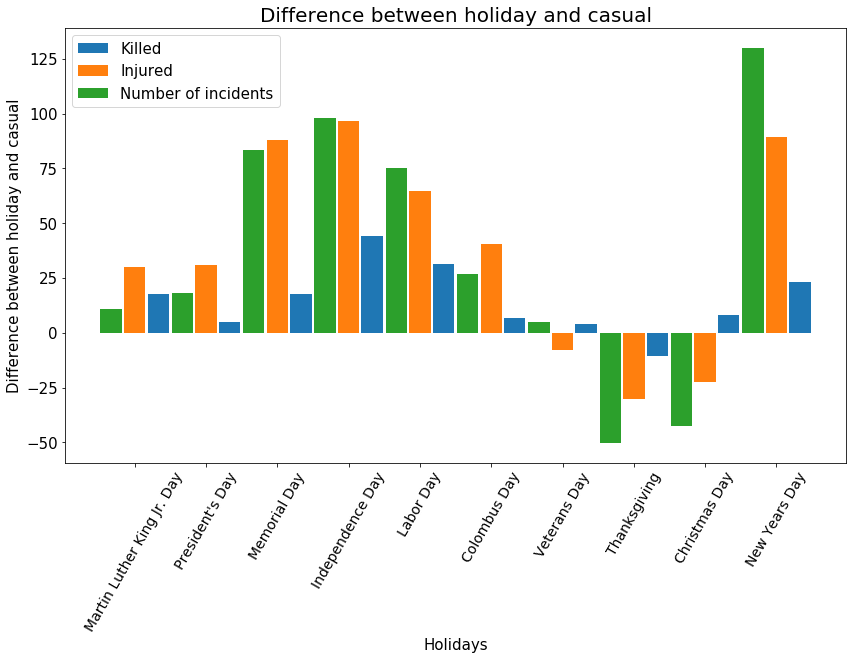

In [72]:
fig = plt.figure(figsize=(14, 8))
ax = plt.axes()
plt.bar(np.arange(h_k.shape[0]) + 0.33, h_k, width=0.3, label='Killed')
plt.bar(np.arange(h_k.shape[0]) - 0, h_i, width=0.3, label='Injured')
plt.bar(np.arange(h_k.shape[0]) - 0.33, h_t, width=0.3, label='Number of incidents')
plt.legend(fontsize=15)
plt.title('Difference between holiday and casual', fontdict={'fontsize' : 20})

ax.xaxis.set_major_locator(ticker.FixedLocator((np.arange(h_k.shape[0]))))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((holiday_names)))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60, fontsize=14)
plt.yticks(fontsize=15)
plt.xlabel('Holidays', fontsize=15)
plt.ylabel('Difference between holiday and casual', fontsize=15);

### There are increment of gun violence on holidays. Let's consider amount of killed and injured. There are more of them on New Year, Memorial, Independence and Labor Days than on casual days. And reducing on Christmas, Thanksgiving and Veterans Day.

In [73]:
# population for July 1 2016 
# Source: U.S. Census Bureau, Population Division
state_pop = pd.read_excel('nst-est2016-01.xlsx', skiprows=3, usecols=[0, 9])\
.rename(columns={2016: 'population', 'Unnamed: 0': 'state'})
state_pop['state'] = state_pop['state'].str.replace('.', '')
state_pop.head(6)

,state,population
0,United States,323127513.0
1,Northeast,56209510.0
2,Midwest,67941429.0
3,South,122319574.0
4,West,76657000.0
5,Alabama,4863300.0


In [74]:
def state_stats(df, year=None):
    # Make a table with state's statistic each year
    if year:
        df = df.loc[df['year'] == year]
    
    temp = df.reset_index().groupby(by=['state'])\
    .agg({'n_killed': 'sum', 'n_injured': 'sum', 'n_killed_injured': 'sum', 'incident_id': 'count'})\
    .sort_values(by='n_killed', ascending=False).reset_index().rename(columns={'incident_id': 'count_incidents'})

    temp['avg_killed'] = temp['n_killed'] / temp['count_incidents']
    temp['avg_injured'] = temp['n_injured'] / temp['count_incidents']

    temp = temp.merge(state_pop)

    # density of something on 100000 people 
    temp['den_killed'] = temp['n_killed'] * 100000 / temp['population']
    temp['den_injured'] = temp['n_injured'] * 100000  / temp['population']
    temp['den_both'] = temp['n_killed_injured'] * 100000  / temp['population']
    
    return temp

In [75]:
temp = state_stats(df)
temp.head()

,state,n_killed,count_incidents,n_killed_injured,n_injured,avg_killed,avg_injured,population,den_killed,den_injured,den_both
0,California,5490,16245,12986,7496,0.337950,0.461434,39250017.0,13.987255,19.098081,33.085336
1,Texas,5011,13556,11071,6060,0.369652,0.447035,27862596.0,17.984685,21.749589,39.734273
2,Florida,3884,15013,10917,7033,0.258709,0.468461,20612439.0,18.842991,34.120174,52.963165
3,Illinois,3388,17524,16809,13421,0.193335,0.765864,12801539.0,26.465568,104.838957,131.304525
4,Ohio,2488,10223,8153,5665,0.243373,0.554143,11614373.0,21.421733,48.775771,70.197504


In [76]:
def state_rank(df, stat_rank, asc, top=10):
    # Rank states for column stat_rank
    temp = df.sort_values(by=stat_rank, ascending=asc)[:top]['state'].reset_index().reset_index()
    temp['place'] = temp['level_0'] + 1
    temp = temp[['state', 'place']]
    
    return temp

In [77]:
# Rank states for columns, such as average amount of killed in incident and e.t.c.
top = 10

largest_avg_killed = state_rank(temp, 'avg_killed', False, top)
largest_den_killed = state_rank(temp, 'den_killed', False, top)

smallest_avg_killed = state_rank(temp, 'avg_killed', True, top)
smallest_den_killed = state_rank(temp, 'den_killed', True, top)

In [78]:
# Mean coordinate for every state except Hawaii and Alaska
coordinate = df.groupby(by=['state'])[['longitude', 'latitude']].mean().reset_index()

# Change their coordinate, so they are fit on map
coordinate.loc[coordinate['state'] == 'Hawaii', ['longitude', 'latitude']] = (-120, 29)
coordinate.loc[coordinate['state'] == 'Alaska', ['longitude', 'latitude']] = (-80, 46)

# Add abbreviation of state name
coordinate['abbr'] = coordinate['state'].str[:4]
# make them unique
coordinate.loc[24, 'abbr'] = 'Missis'
coordinate.loc[[29, 30, 31, 32, 33, 34], 'abbr'] = ('NHam', 'NJer', 'NMex', 'NYork', 'NCar', 'NDak')
coordinate.loc[[40,41], 'abbr'] = ('SCar', 'SDak')

In [79]:
largest_avg_killed = largest_avg_killed.merge(coordinate)
largest_den_killed = largest_den_killed.merge(coordinate)

smallest_avg_killed = smallest_avg_killed.merge(coordinate)
smallest_den_killed = smallest_den_killed.merge(coordinate)

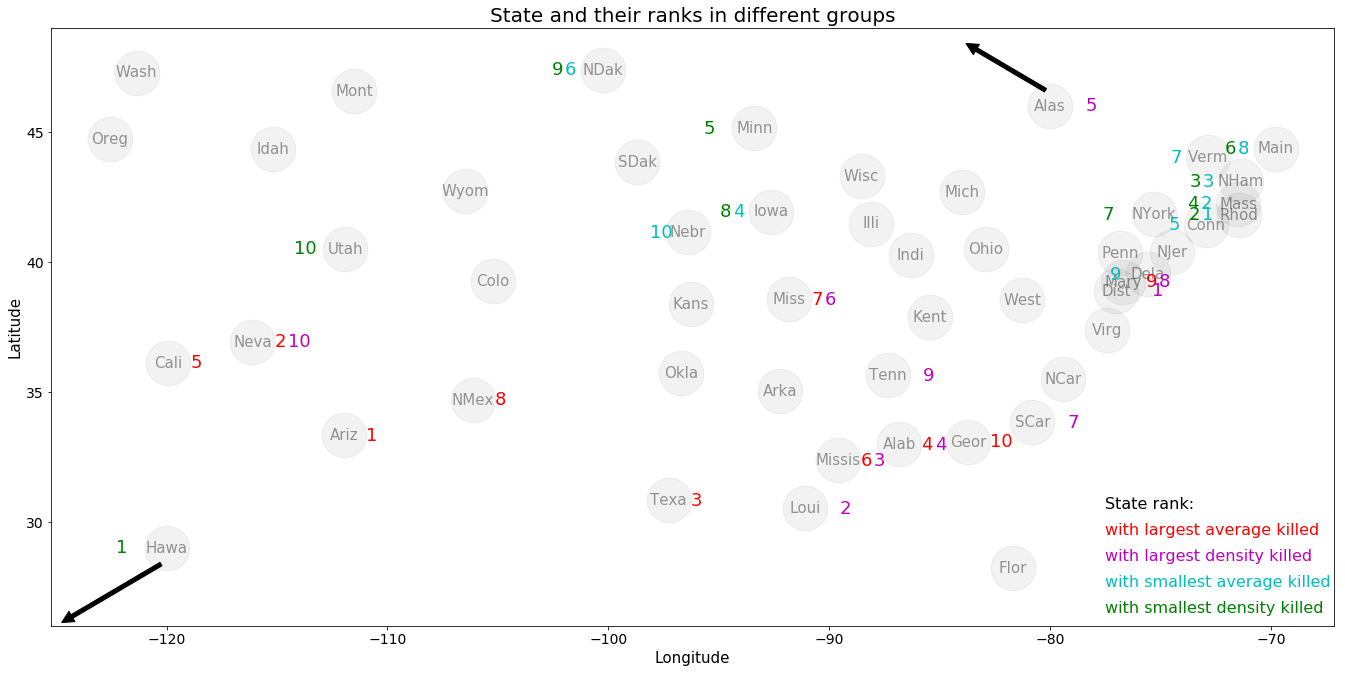

In [80]:
fig = plt.figure(figsize=(23, 11))

# Make transparent circle around state's name
plt.scatter(coordinate['longitude'], coordinate['latitude'], alpha=0.05, color='k', s=2000, label='center of state')
plt.ylim((26, 49))

# Show true direction where Alaska and  Hawaii should be located
plt.annotate('', xy=(-125, 26), xytext=(-120, 28.5),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('', xy=(-84, 48.5), xytext=(-80, 46.5),
            arrowprops=dict(facecolor='black', shrink=0.05))

c = ['k', 'r', 'm', 'c', 'g']
# Show name of states
data = coordinate
for i in range(data.shape[0]):
    _ = data.iloc[i]
    plt.text(_['longitude'], _['latitude'], s=_['abbr'], 
                         alpha=0.4, fontsize=15, color=c[0], va='center', ha='center')

# Show states' ranks in 'good' list
for j, data in enumerate([largest_avg_killed, largest_den_killed]):
    for i in range(data.shape[0]):
        _ = data.iloc[i]
        plt.text(_['longitude'] + 1. + 0.6 * j, _['latitude'] - 0.2, s=_['place'], fontsize=18, color=c[j+1])    

# Show states' ranks in 'bad' list
for j, data in enumerate([smallest_avg_killed, smallest_den_killed]):
    for i in range(data.shape[0]):
        _ = data.iloc[i]
        plt.text(_['longitude'] - 1.7 - 0.6 * j, _['latitude'] - 0.2, s=_['place'], fontsize=18, color=c[j+3]) 

log_s, lat_s = -77.5, 30.5
plt.text(log_s, lat_s, s='State rank:', color=c[0], fontsize=16)
plt.text(log_s, lat_s - 1, s='with largest average killed', color=c[1], fontsize=16)
plt.text(log_s, lat_s - 2, s='with largest density killed', color=c[2], fontsize=16)
plt.text(log_s, lat_s - 3, s='with smallest average killed', color=c[3], fontsize=16)
plt.text(log_s, lat_s - 4, s='with smallest density killed', color=c[4], fontsize=16)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('State and their ranks in different groups', fontsize=20);

In [81]:
# Build table with states' ranks with largetest average killed in incident and density of killed on 100000 people
smallest = False
for i, stat in enumerate(['avg_killed', 'den_killed']):
    for year in range(2014, 2018):
        temp = state_stats(df, year)
        temp = state_rank(temp, stat, smallest, 51).rename(columns={'place': stat[:5] + '_' + str(year)})
        if year == 2014 and i == 0:
            prev = temp.copy()
            continue
        else:
            prev = prev.merge(temp, on='state')

# Make table with changes of ranks in years. Columns for 2014 is initial rank 
changes = prev.copy()
for stat in ['avg_k', 'den_k']:
    for year in range(2015, 2018):
        changes[stat + '_' + str(year)] = changes[stat + '_' + str(year)] - prev[stat + '_' + str(year-1)]

changes.head(5)

,state,avg_k_2014,avg_k_2015,avg_k_2016,avg_k_2017,den_k_2014,den_k_2015,den_k_2016,den_k_2017
0,Nevada,1,3,-1,-1,10,-1,2,1
1,Arizona,2,-1,0,0,29,3,-4,-1
2,California,3,0,3,3,27,8,-2,-2
3,Texas,4,1,0,-2,22,0,1,3
4,Missouri,5,7,-4,-3,6,-2,2,-1


In [82]:
# Build table with states' ranks with smallest average killed in incident and density of killed on 100000 people
smallest = True
for i, stat in enumerate(['avg_killed', 'den_killed']):
    for year in range(2014, 2018):
        temp = state_stats(df, year)
        temp = state_rank(temp, stat, smallest, 51).rename(columns={'place': stat[:5] + '_' + str(year)})
        if year == 2014 and i == 0:
            prev = temp.copy()
            continue
        else:
            prev = prev.merge(temp, on='state')

# Make table with changes of ranks in years. Columns for 2014 is initial rank 
changes = prev.copy()
for stat in ['avg_k', 'den_k']:
    for year in range(2015, 2018):
        changes[stat + '_' + str(year)] = changes[stat + '_' + str(year)] - prev[stat + '_' + str(year-1)]

changes.head(5)

,state,avg_k_2014,avg_k_2015,avg_k_2016,avg_k_2017,den_k_2014,den_k_2015,den_k_2016,den_k_2017
0,Rhode Island,1,0,0,0,6,-4,-1,1
1,New Hampshire,2,2,-1,4,4,0,-1,2
2,Delaware,3,7,-2,5,43,-1,-14,5
3,Massachusetts,4,-2,0,0,2,1,1,3
4,Vermont,5,1,3,3,20,-14,2,-5


### There are some stable states, such as Rhode Island. But mostly there aren't any monotonic changes in states' ranks.

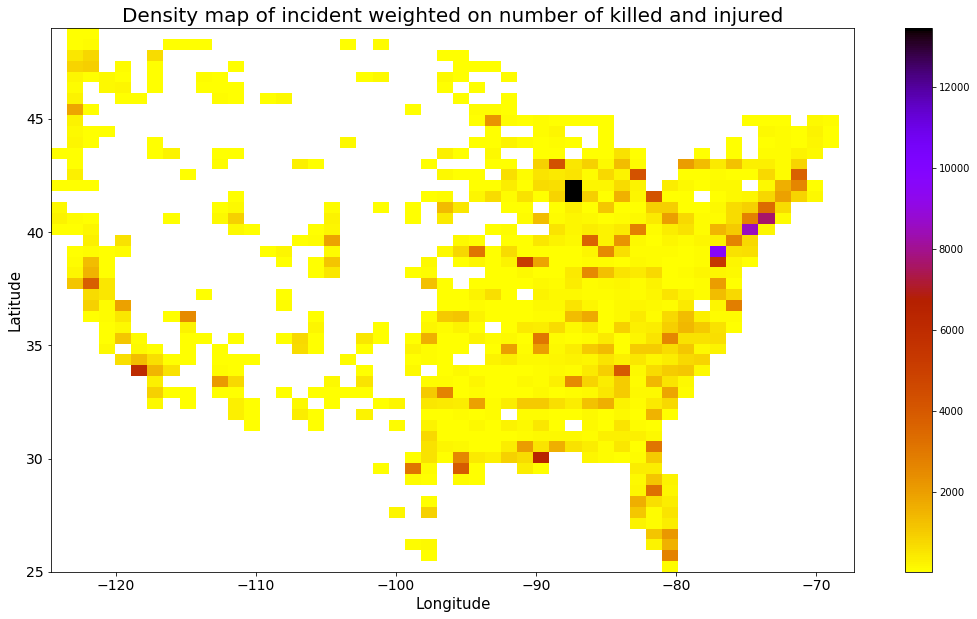

In [83]:
fig = plt.figure(figsize=(18, 10))

temp2 = df.loc[df['longitude'].between(-125, -40) & df['latitude'].between(25, 50), :]
plt.hist2d(temp2['longitude'].dropna(), temp2['latitude'].dropna(), cmin=20,
           weights=temp2['n_killed_injured'].values + 1, 
           bins=50, cmap='gnuplot_r')
plt.colorbar()
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Density map of incident weighted on number of killed and injured', fontsize=20);

### There are spots on a map with very high amount of incident, let's consider city level. Maybe some of them made something to decrease amount of incident.

In [84]:
def city_stats(df, year=None):
    # Make a table with city's statistic each year
    if year:
        df = df.loc[df['year'] == year]
    
    temp = df.reset_index().groupby(by=['city_or_county'])\
    .agg({'n_killed': 'sum', 'n_injured': 'sum', 'n_killed_injured': 'sum', 'incident_id': 'count'})\
    .sort_values(by='n_killed', ascending=False).reset_index().rename(columns={'incident_id': 'count_incidents'})

    temp['avg_killed'] = temp['n_killed'] / temp['count_incidents']
    temp['avg_injured'] = temp['n_injured'] / temp['count_incidents']
    
    temp = temp.loc[:, ['city_or_county', 'avg_killed', 'avg_injured', 'count_incidents']]\
    .sort_values(by='avg_killed', ascending=False)
    
    return temp

In [85]:
for year in range(2014, 2018):
    temp = city_stats(df, year=year).rename(columns={'avg_killed': 'avg_k' + '_' + str(year),
                                                     'avg_injured': 'avg_i' + '_' + str(year),
                                                     'count_incidents': 'count' + '_' + str(year)})
    if year == 2014:
        prev = temp.copy()
        continue
    else:
        prev = prev.merge(temp, on='city_or_county')
        
# remove city with less than 100 incidents
prev = prev.loc[(prev['count_2014'] > 100) | (prev['count_2017'] > 100) ]

# Make table with changes in stats in years. Columns for 2014 is initial rank 
changes = prev.copy()
for stat in ['avg_k', 'avg_i', 'count']:
    for year in range(2015, 2018):
        changes[stat + '_' + str(year)] = changes[stat + '_' + str(year)] - prev[stat + '_' + str(year-1)]
        
changes[['city_or_county'] + [stat + '_' + str(year)
                              for stat in ['avg_k', 'avg_i', 'count']
                              for year in range(2014, 2018)]]\
.sort_values(by='count_2014', ascending=False).head()

,city_or_county,avg_k_2014,avg_k_2015,avg_k_2016,avg_k_2017,avg_i_2014,avg_i_2015,avg_i_2016,avg_i_2017,count_2014,count_2015,count_2016,count_2017
1033,Chicago,0.202742,-0.020310,0.009625,0.011857,0.927032,0.060299,-0.024115,0.007958,2042,326,704,-262
1029,Philadelphia,0.205153,0.144380,-0.009624,0.050797,0.775763,0.031713,-0.066961,0.044338,1048,-513,124,-78
1265,Washington,0.114118,0.120964,-0.027788,-0.116773,0.356471,0.276441,0.033115,-0.369699,850,-297,-32,650
980,Baltimore,0.226316,0.063476,-0.002523,-0.015686,0.581579,0.091308,-0.039590,-0.047865,760,151,8,193
1018,New Orleans,0.215040,0.052653,-0.058755,0.004415,0.568602,0.005245,0.019149,0.106569,758,-108,178,-139


In [86]:
# cities with decreased amount of inciddent in time
good_cities = prev.loc[prev['count_2014'] - prev['count_2017'] >= 0, 
                       ['city_or_county'] + [stat + '_' + str(year) for stat in ['avg_k', 'avg_i', 'count'] 
                                             for year in range(2014, 2018)]]

bad_cities = prev.loc[prev['count_2014'] - prev['count_2017'] < 0, 
                       ['city_or_county'] + [stat + '_' + str(year) for stat in ['avg_k', 'avg_i', 'count'] 
                                             for year in range(2014, 2018)]]

In [87]:
city_coordinates = df.groupby(by='city_or_county')[['longitude', 'latitude']].mean().reset_index()

# Remove Alaska and Hawaii's cities from map
city_coordinates = city_coordinates.loc[(city_coordinates['latitude']<52) & (city_coordinates['longitude'] > -125),:]

good_cities = good_cities.merge(city_coordinates, on='city_or_county', how='inner')
bad_cities = bad_cities.merge(city_coordinates, on='city_or_county', how='inner')

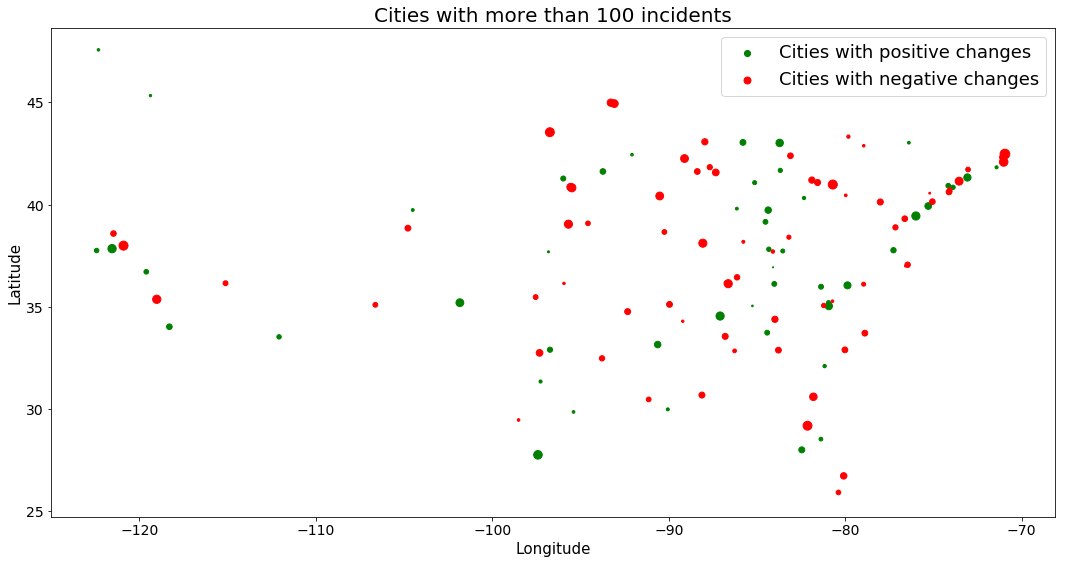

In [88]:
fig = plt.figure(figsize=(18, 9))

# Scale circles to show amount changes of incidents
good_weight = 100 * np.abs(good_cities['count_2014'] - good_cities['count_2017']) / good_cities['count_2014']
bad_weight = 100 * np.abs(bad_cities['count_2014'] - bad_cities['count_2017']) / bad_cities['count_2017']

plt.scatter(good_cities['longitude'], good_cities['latitude'], color='g', s=good_weight, 
            label='Cities with positive changes')
plt.scatter(bad_cities['longitude'], bad_cities['latitude'], color='r', s=bad_weight, 
            label='Cities with negative changes')
plt.legend(fontsize=18)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Cities with more than 100 incidents', fontsize=20);

### There are plenty of example of both city types. But it doesn't seem what any particular state has successful strategy for reduction gun violence.